In [1]:
import math
import requests
import json

# Define the coordinate to check
y = 51.920175
x = 5.969967

################################## GET ENVIROMENT TYPE ###################################
# Build the OSM API query URL
url = 'https://nominatim.openstreetmap.org/reverse?format=json&lat={}&lon={}&zoom=18&addressdetails=1'.format(y, x)

# Send a GET request to the API and get the response
response = requests.get(url)

# Parse the response JSON data
data = json.loads(response.content)

# Check type
if 'city' in data['address']:
    print('The coordinates are in the city of', data['address']['city'])
    enviroment = "city"
elif 'village' in data['address']:
    print('The coordinates are in the village of', data['address']['village'])
    enviroment = "village"
else:
    print('The coordinates are in the plains.')
    enviroment = "plains"

################################# GET FLOOD DEPTHS #########################################
# Define the bounding box in EPSG:4326 (WGS84) coordinates as [min_lon, min_lat, max_lon, max_lat]
x1 = x + 0.0001
y1 = y + 0.0001
bbox = [y, x, y1, x1]

# Convert the bbox list to a string
bbox_str = ','.join(str(coord) for coord in bbox)

# Define the common URL parameters
params = {
    "SERVICE": "WMS",
    "VERSION": "1.3.0",
    "REQUEST": "GetFeatureInfo",
    "FORMAT": "image/png",
    "TRANSPARENT": "true",
    "INFO_FORMAT": "application/json",
    "FEATURE_COUNT": "8",
    "I": "50",
    "J": "50",
    "CRS": "EPSG:4326",
    "STYLES": "",
    "WIDTH": "101",
    "HEIGHT": "101",
    "BBOX": bbox_str,
    "x": x,
    "y": y,
}

# Define a dictionary to store the responses
responses = {}

# Define a list of layers to query
layers = ["overstromingsdiepte_extreem_kleine_kans", "overstromingsdiepte_kleine_kans", "overstromingsdiepte_middelgrote_kans", "overstromingsdiepte_grote_kans"]

# Loop over the layers and make separate requests for each layer
for layer in layers:
    params["QUERY_LAYERS"] = layer
    params["LAYERS"] = layer
    
    # Construct the URL using string formatting
    url = "https://apps.geodan.nl/public/data/org/gws/YWFMLMWERURF/kea_public/wms?v1_0&" + "&".join("{}={}".format(k, v) for k, v in params.items())
    
    # Send the request and parse the JSON response
    response = requests.get(url)
    data = response.json()
    
    # Store the response in the dictionary
    responses[layer] = data

    # Extract the "properties" field from the response
    properties = data["features"][0]["properties"]
    
    # Get the "GRAY_INDEX" value and check if it's -9999
    gray_index = properties['GRAY_INDEX']
    if gray_index == -9999:
        gray_index = 0

    # Store the numerical value in the corresponding variable
    if layer == "overstromingsdiepte_extreem_kleine_kans":
        extreem_kleine_kans_val = gray_index
    elif layer == "overstromingsdiepte_kleine_kans":
        kleine_kans_val = gray_index
    elif layer == "overstromingsdiepte_middelgrote_kans":
        middelgrote_kans_val = gray_index
    elif layer == "overstromingsdiepte_grote_kans":
        grote_kans_val = gray_index

print(extreem_kleine_kans_val, kleine_kans_val, middelgrote_kans_val, grote_kans_val)

################################### GET COLUMN PROPERTIES ########################################
# Loaded info (wood, steel & concrete possible)
connection = "fixed" 
material = "concrete" 
Length = 3 
Height = 0.1 
Width = 0.1 
Thickness = 0.07


########################## GET WATER TYPE AND FLOOD DEPTH + FLOOD RISK #########################
WaterType = "salt" # majority of seas and rivers in the netherlands are salty

The coordinates are in the plains.
3.960925817489624 3.696451425552368 3.232856273651123 2.099125862121582


In [16]:
################################### GET VALUES FROM GIVEN VARIABLES ################################
#  Modulus of elasticity in MPa
match material:
    case "concrete":
        Elasticity =  30 * 1000    # MPA concrete C20/25
    case "wood":
        Elasticity =  11 * 1000  # MPA wood 
    case "steel":
        Elasticity =  210 * 1000   # MPA steel 

# Second moment of area in m4
match material:
    case "concrete":
        WidthMM = Width * 1000
        HeightMM = Height * 1000
        Inertia = (((WidthMM * (HeightMM**3))) / 12 ) #
    case "wood":
        WidthMM = Width * 1000
        HeightMM = Height * 1000
        Inertia = (((WidthMM * (HeightMM**3))) / 12 ) #
    case "steel":
        # Inertia = 14920 * 10**-8 # cm^4 to m4 steel HE 320A
        WidthMM = Width * 1000
        HeightMM = Height * 1000
        ThicknessMM = Thickness * 1000
        # https://www.engineeringtoolbox.com/area-moment-inertia-d_1328.html symmetrical shape
        # Inertia = (((ThicknessMM * (HeightMM**3)) / 12) + ((WidthMM / 12)* ((HeightMM**3)) - ((HeightMM**3)*(1/5))) * -1) 
        Inertia = 3692 * (10**4)

# specific weights per water type
match WaterType:
    case "salt":
        SpecificWeightWater = 64.0 * 16.0185 # lb/ft3 to kg/m3
    case "fresh":
        SpecificWeightWater = 62.4 * 16.0185 # lb/ft3 to kg/m3

# Debris weight
match enviroment:
    case "city":
        DebrisWeight =  1500 # car weight
    case "village":
        DebrisWeight =  655 # tree weight https://www.researchgate.net/figure/Summary-of-tree-heights-weights-and-volumes_tbl1_232354725
    case "plains":
        DebrisWeight =  454 # wood weight

# t = duration of impact in seconds
match material:
# City of Honolulu building code for impact durations
    case "concrete":
        impacttime = 0.1 # second
    case "wood":
        impacttime = 1 # second 
    case "steel":
        impacttime = 0.5 # second

# Max deflection limits Column
match material:
     # Source: Eurocode 5, 3, 2 (in order)
    case "concrete":
        PermittedDeflection =  (Length * 1000) / 240 # EUC 5 Concrete
    case "wood":
        PermittedDeflection =  (Length * 1000) / 240 # EUC 3 wood 
    case "steel":
        PermittedDeflection =  (Length * 1000) / 240 # EUC 2 steel

# match material to repair time
match material:
    # Source: PACT FEMA, 1 2 3 represents repair class
    case "concrete":
        recoverydays1 = 23
        recoverydays2 = 35
        recoverydays3 = 43
    case "wood":
        recoverydays1 = 4
        recoverydays2 = 9
        recoverydays3 = 30
    case "steel":
        recoverydays1 = 25
        recoverydays2 = 31
        recoverydays3 = 36


In [17]:
# define the four different design stillwater depths
design_stillwater_depths = [extreem_kleine_kans_val, kleine_kans_val, middelgrote_kans_val, grote_kans_val]
loop = 0
damagepercentagelist = []
recoverydayslist = []
preparationdayslist = []


# design_stillwater_depths = [3, 3, 3, 3] # use this to have custom flood depth inputs for each probability 

for DesignStillwaterDepth in design_stillwater_depths:
    print(layers[loop])
    loop += 1 
    if DesignStillwaterDepth != 0:
        GravitationalConstant = 9.81 # m/s
        Velocity = (GravitationalConstant * DesignStillwaterDepth)**0.5 # V = (gds)0.5

        # Breaking wave calculation
        def breakingwave():
            DragCoefficient = 2.25 # if square
            HeightMetric = Height * 0.3048
            BreakingWaveOnPiles = 0.5 * DragCoefficient * SpecificWeightWater * HeightMetric * (DesignStillwaterDepth**2)
            return BreakingWaveOnPiles

        # Hydrostatic
        def hydrostatic():
            HydrostaticLoadPerWidth = 0.5 * SpecificWeightWater * (DesignStillwaterDepth**2) # kg
            HydrostaticLoad = HydrostaticLoadPerWidth * Width
            return HydrostaticLoad

        # Couldn't convert to metric, thus this function will be in imperial
        # Hydrodynamic (Fluid dynamics)
        def hydrodynamic():
            CrossArea = Height * Width
            DragCoefficient = 2 # square
            match WaterType:
                case "salt":
                    MassDensityFluid = 1.99  # slugs/ft3 
                case "fresh":
                    MassDensityFluid = 1.94  # slugs/ft3 
            VelocityImp = Velocity * 3.2808399
            CrossAreaImp = CrossArea * 10.7639
            HydrodynamicLoad = 0.5 * DragCoefficient * MassDensityFluid * (VelocityImp**2) * CrossAreaImp
            # HydrodynamicLoad = HydrodynamicLoad * 0.453592
            return HydrodynamicLoad

        def debrisimpact():
            DebrisLoad = (DebrisWeight * Velocity) / (GravitationalConstant * impacttime)
            return DebrisLoad

        # Calculate all necessary loads
        BreakingWaves = breakingwave()
        HydrodynamicLoad = hydrodynamic()
        HydrostaticLoad = hydrostatic()
        DebrisLoad = debrisimpact()

        print("For Design Stillwater Depth:", DesignStillwaterDepth)
        # print("breaking", BreakingWaves, "hydrodynamic", HydrodynamicLoad, "hydrostatic", HydrostaticLoad, "debris", DebrisLoad)

        # convert weight into forces
        LoadBreak = (BreakingWaves * GravitationalConstant) / 1000 # Fz (kN) = m*g / 1000 
        LoadCombination = ((HydrodynamicLoad + HydrostaticLoad) * GravitationalConstant) / 1000 # Fz (kN) = m*g / 1000 
        LoadDebris = (DebrisLoad * GravitationalConstant) / 1000 # Fz (kN) = m*g / 1000 

        print("breaking", LoadBreak, "kN", "hydrodynamic + hydrostatic", LoadCombination, "kN", "Debris", LoadDebris, "kN")

        # calculate max deflection for both breaking loads and the load combination
        def deflection(Load):
            # formula from https://structx.com/Beam_Formulas_014.html
            if connection == "fixed":
                MaxDeflection = ((Load * ((DesignStillwaterDepthMM * 2/3) ** 3) * ((DesignStillwaterDepthMM * 1/3) ** 2)) / (12 * Elasticity * Inertia * (LengthMM ** 3))) * ((3 * LengthMM) + (DesignStillwaterDepthMM * 1/3))
            # formula from https://structx.com/Beam_Formulas_008.html
            elif connection == "hinge":
                MaxDeflection = (Load * ((DesignStillwaterDepthMM * 1/3) ** 2) * ((DesignStillwaterDepthMM * 2/3) ** 2)) / (3 * Elasticity * Inertia * LengthMM)
            return MaxDeflection
            
        LengthMM = Length * 1000
        DesignStillwaterDepthMM = DesignStillwaterDepth * 1000
        LoadBreakN = LoadBreak * 1000
        LoadCombinationN = LoadCombination * 1000
        LoadDebrisN = LoadDebris * 1000

        MaxdefBreak = deflection(LoadBreakN) 
        MaxdefCombination = deflection(LoadCombinationN) 
        MaxdefDebris = deflection(LoadDebrisN) 

        # check if max deflection exceeds permitted deflection
        def delfectioncheck(MaxDeflection):
            if (MaxDeflection) > PermittedDeflection:
                print("Deflection: Risk detected", "permitted amount is", round(PermittedDeflection, 3), "mm occuring amount is", round(MaxDeflection, 4), "mm")
                probability = False
            else:
                print("Deflection: Column is OK", "permitted amount is", round(PermittedDeflection, 3), "mm occuring amount is", round(MaxDeflection, 4), "mm")
                probability = True
            return probability

        deflection_checks = [("Breaking Loads", MaxdefBreak ), ("Hydrostatic and Hydrodynamic Loads", MaxdefCombination ), ("Debris Loads", MaxdefDebris )]

        FloodProbabilityList = []

        for load_type, max_deflection in deflection_checks:
            if not delfectioncheck(max_deflection):
                if max_deflection >= (PermittedDeflection * 2.7): # heavy damage
                    FloodProbabilityList.append("Class3")
                elif max_deflection >= (PermittedDeflection * 1.67): # moderate damage
                    FloodProbabilityList.append("Class2")
                else: # checks for maxdeflection * 1
                    FloodProbabilityList.append("Class1")
            else:
                FloodProbabilityList.append(0)

        print(FloodProbabilityList)
        
        # repair class 3
        if "Class3" in FloodProbabilityList:
            Damagepercentage = (0.13 * math.sqrt(DesignStillwaterDepth))
            damagepercentagelist.append(Damagepercentage)
            recoverydays = recoverydays3 / 365
            # inspection - design phase - funding - contractor - permit
            preparationdays = 10 + (75 * 7) + (25 * 7) + (39 * 7) + (12 * 7)
            preparationdays = preparationdays / 365
            recoverydayslist.append(recoverydays)
            preparationdayslist.append(preparationdays)
        # repair class 2
        elif "Class2" in FloodProbabilityList:
            Damagepercentage = (0.13 * math.sqrt(DesignStillwaterDepth))
            damagepercentagelist.append(Damagepercentage)
            recoverydays = recoverydays2 / 365
            # inspection - design phase - funding - contractor - permit
            preparationdays = 10 + (20 * 7) + (25 * 7) + (39 * 7) + (7.5 * 7)
            preparationdays = preparationdays / 365
            recoverydayslist.append(recoverydays)
            preparationdayslist.append(preparationdays)
        # repair class 1
        elif "Class1" in FloodProbabilityList:
            Damagepercentage = (0.13 * math.sqrt(DesignStillwaterDepth))
            damagepercentagelist.append(Damagepercentage)
            recoverydays = recoverydays1 / 365
            # inspection - design phase - funding - contractor - permit
            preparationdays = 10 + (10 * 7) + (25 * 7) + (15 * 7) + (3 * 7)
            preparationdays = preparationdays / 365
            recoverydayslist.append(recoverydays)
            preparationdayslist.append(preparationdays)
        else:
            Damagepercentage = 0
            damagepercentagelist.append(Damagepercentage)
            recoverydays = 0
            preparationdays = 0
            recoverydayslist.append(recoverydays)
            preparationdayslist.append(preparationdays)
        
    else: 
        print("This location has no determined risk for flooding by Klimapedia")
        Damagepercentage = 0
        recoverydays = 0
        preparationdays = 0
        recoverydayslist.append(recoverydays)
        preparationdayslist.append(preparationdays)
        damagepercentagelist.append(Damagepercentage)

print(damagepercentagelist)
print(recoverydayslist)
print(preparationdayslist)

flood depth extremely low chance
For Design Stillwater Depth: 3
breaking 3.103707755894401 kN hydrodynamic + hydrostatic 5.191334178804663 kN Debris 24.62923847787422 kN
Deflection: Column is OK permitted amount is 12.5 mm occuring amount is 3.0654 mm
Deflection: Column is OK permitted amount is 12.5 mm occuring amount is 5.1272 mm
Deflection: Risk detected permitted amount is 12.5 mm occuring amount is 24.3252 mm
[0, 0, 'Class2']
flood depth low chance
For Design Stillwater Depth: 3
breaking 3.103707755894401 kN hydrodynamic + hydrostatic 5.191334178804663 kN Debris 24.62923847787422 kN
Deflection: Column is OK permitted amount is 12.5 mm occuring amount is 3.0654 mm
Deflection: Column is OK permitted amount is 12.5 mm occuring amount is 5.1272 mm
Deflection: Risk detected permitted amount is 12.5 mm occuring amount is 24.3252 mm
[0, 0, 'Class2']
flood depth middle chance
For Design Stillwater Depth: 3
breaking 3.103707755894401 kN hydrodynamic + hydrostatic 5.191334178804663 kN Debri

2 5
29.068883707497267


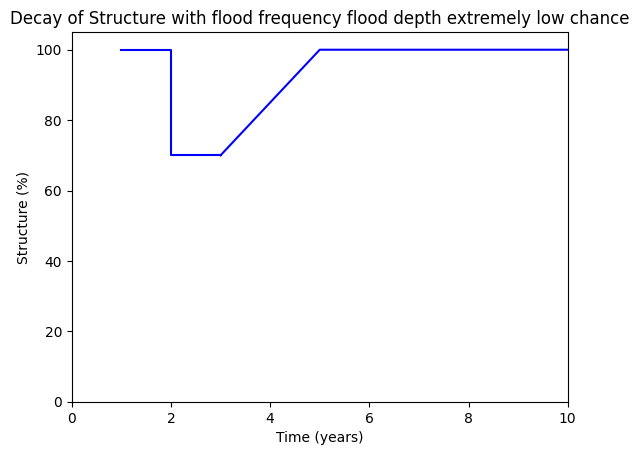

2 5
26.0


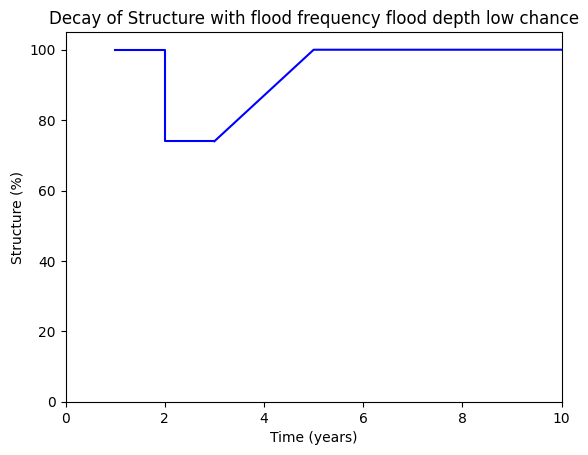

2 4
22.516660498395407


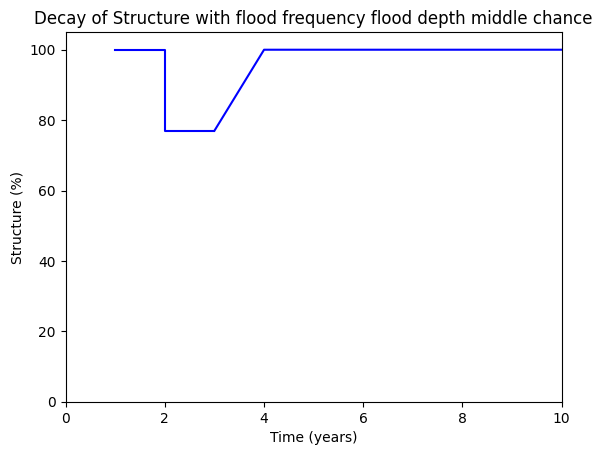

2 2
0


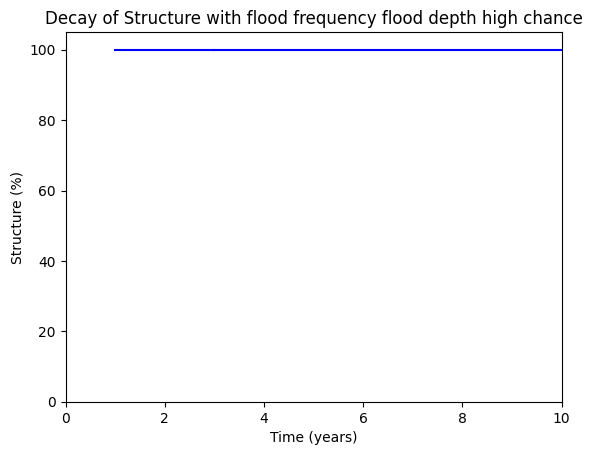

In [4]:
import matplotlib.pyplot as plt
import numpy as np

layers = ["flood depth extremely low chance", "flood depth low chance", "flood depth middle chance", "flood depth high chance"]
index = [0, 1, 2, 3]  # amount of scenarios

# damagepercentagelist = [0.2, 0.3, 0.4, 0.5]
# recoverydayslist = [2, 2, 2, 2]
# preparationdayslist = [2, 2, 2, 2] 

scales = [10, 10, 10, 10]

for i in index:
    # Define the formula for y
    x = np.arange(1, scales[i] + 1)  # x values from 1 to scales[i]
    y = np.zeros_like(x)  # Initialize Y values as an array of zeros 
    z = np.zeros_like(x)  # Initialize Y values as an array of zeros 

    s = 2  # year of flood event
    s1 = 2 # same year as flood event
    recoverytimestart = round(recoverydayslist[i] + s1)
    recoverytimeend = round(recoverydayslist[i] + s1 + preparationdayslist[i])
    print(recoverytimestart, recoverytimeend)

    damagedealt = 100 * damagepercentagelist[i]
    print(damagedealt)
    
    y[:s] = 100  # initial structure
    y[s:s1] = 100 - (100 * damagepercentagelist[i])  # flood damage
    y[s1] = 100 - (100 * damagepercentagelist[i])  # flood damage
    z[:s1] = 100 - (100 * damagepercentagelist[i])  # flood damage
    z[s1:recoverytimestart] = 100 - damagedealt  # stable period
    z[recoverytimestart:recoverytimeend] = np.linspace(100 - damagedealt, 100, recoverytimeend - recoverytimestart)
    z[recoverytimeend:] = 100

    color = 'blue'  # Set the color for both graphs

    # Plot the graph
    plt.step(x[:s+1], y[:s+1], color=color)  # Plotting only up to x = 5 for y
    plt.plot(x[s1:], z[s1:], color=color)  # Plotting from x = 5 for z
    plt.title("Decay of Structure with flood frequency " + layers[i])
    plt.xlabel("Time (years)")
    plt.ylabel("Structure (%)")
    plt.ylim(0, 105)
    plt.xlim(0, scales[i])
    plt.show()

    